# [Part.2]

## 2. Check function
- resize -- crop,pad
- flip left_right
- rotate -- degree 10,90,120,180,200,270,300
- translate(x-axis)
- translate(y-axis)
- shear(x-axis)
- shear(y-axis)

## 3. Test crop_bbox code
- Before crop bboxes
- After crop bboxes
- padding images after crop images

### 1. Run preprocess function -- Part.1
### 4. Test function that process bboxes before and after executing preprocess function -- Part.3
### 5. Test reduce_min & reduce_max -- Part.3


In [1]:
from pathlib import Path

import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

class DatasetGenerator(object):
    def __init__(self, data_dir, input_size, output_size, batch_size):
        self.data_dir = Path(data_dir)
        self.input_size = input_size
        self.output_size = output_size
        self.batch_size = batch_size
        self._num_bbox = 0

    def run(self, train_num_bbox, val_num_bbox, preprocessed=None):
        return self.get_tfdataset(
            train=True, num_bbox=train_num_bbox,
            preprocessed=preprocessed), self.get_tfdataset(
                train=False, num_bbox=val_num_bbox)

    def get_tfdataset(self, train, num_bbox, preprocessed=None):
        self._num_bbox = num_bbox
        tfrecords_dir = self.data_dir / 'tfrecords' / f'{"train" if train else "val"}_{self.input_size}'
        tfrecords_files = [str(f) for f in tfrecords_dir.glob('*.tfrecords')]
        tfrecords = tf.data.TFRecordDataset(
            tfrecords_files, num_parallel_reads=len(tfrecords_files))
        ds = tfrecords
        if train:
            ds = ds.shuffle(buffer_size=10000, seed=42) 
        ds = ds.map(self._parse_tfrecord,
                    num_parallel_calls=tf.data.experimental.AUTOTUNE)
        if train and preprocessed:
            
            ds = ds.map(self._extract_valid_bboxes,
                         num_parallel_calls=tf.data.experimental.AUTOTUNE)
                
            ds = ds.map(self._convert_image_float32,
                         num_parallel_calls=tf.data.experimental.AUTOTUNE)
            
            for preprocess in preprocessed:
                ds = ds.map(preprocess,
                            num_parallel_calls=tf.data.experimental.AUTOTUNE)
                
            ds = ds.map(self._convert_image_uint8,
                        num_parallel_calls=tf.data.experimental.AUTOTUNE)
            
            ds = ds.map(self._pad_bboxes,
                         num_parallel_calls=tf.data.experimental.AUTOTUNE)
            

        ds = ds.map(lambda i, o: (preprocess_input(tf.cast(i, tf.float32)), o),
                      num_parallel_calls=tf.data.experimental.AUTOTUNE)
        ds = ds.batch(self.batch_size)
        ds = ds.prefetch(tf.data.experimental.AUTOTUNE)    

        return ds

    def _parse_tfrecord(self, tfrecord):
        tf_example = tf.io.parse_single_example(tfrecord,
                                                features={
                                                    'image_raw':
                                                    tf.io.FixedLenFeature(
                                                        (), tf.string),
                                                    'bboxes':
                                                    tf.io.FixedLenFeature(
                                                        (self._num_bbox, 4),
                                                        tf.float32)
                                                })
        image = tf.image.decode_jpeg(tf_example['image_raw'], channels=3)
        bboxes = tf_example['bboxes']
        
        return image, bboxes

    def _convert_image_float32(self, image, bboxes):
        return tf.image.convert_image_dtype(image, tf.float32), bboxes

    def _convert_image_uint8(self, image, bboxes):
        return tf.image.convert_image_dtype(image, tf.uint8), bboxes
    
    def _extract_valid_bboxes(self, image, bboxes):
        valid_bboxes = bboxes[tf.reduce_any(bboxes != 0, axis=-1)]
        return image, valid_bboxes
    
    def _pad_bboxes(self, image, bboxes):
        padded_bboxes = tf.pad(bboxes,[[0, self._num_bbox - tf.shape(bboxes)[0]], [0, 0]],'CONSTANT')
        return image, padded_bboxes


In [2]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import tensorflow as tf

def draw_bbox(image, bboxes):
    plt.imshow(image)
    for bbox in bboxes:
        x1, y1, x2, y2 = bbox
        patch = patches.Rectangle((float(x1), float(y1)), float(x2-x1), float(y2-y1), alpha=0.5)
        plt.gca().add_patch(patch)
    plt.show()
    plt.clf()

In [3]:
import tensorflow as tf
import tensorflow_addons as tfa
import math


def random_factor(minval=0, maxval=None):
    return tf.random.uniform([], minval, maxval, seed=42)


def last_coord_factor(image):
    input_size = tf.cast(tf.shape(image)[0], tf.float32)
    last_coord = input_size - 1
    return last_coord


def random_resize(image,
                  bboxes,
                  run_criteria=0.3,
                  scale_min=0.7,
                  scale_max=1.3):
    do_a_resize_random = random_factor() < run_criteria
    if do_a_resize_random:
        scale_factor = random_factor(scale_min, scale_max)
        adjusted_image = _resize_image(image, scale_factor)
        adjusted_bboxes = _resize_bbox(last_coord_factor(image), bboxes,
                                       scale_factor)
        return adjusted_image, adjusted_bboxes
    else:
        return image, bboxes


def _resize_image(image, scale_factor):
    input_size = tf.cast(tf.shape(image)[0], tf.float32)
    box_indices = 0.5 + 0.5 / tf.convert_to_tensor(
        [[-scale_factor, -scale_factor, scale_factor, scale_factor]])
    resized_image = tf.image.crop_and_resize(
        [image], box_indices, [0],
        [int(input_size), int(input_size)])[0]
    return resized_image


def _resize_bbox(last_coord, bboxes, scale_factor):
    center = last_coord / 2
    resized_bboxes = tf.reshape(bboxes, (-1, 2))
    resized_bboxes = (resized_bboxes - center) @ [[scale_factor, 0],
                                                  [0, scale_factor]] + center
    resized_bboxes = tf.reshape(resized_bboxes, (-1, 4))
    if scale_factor > 1:
        resized_bboxes = _crop_bbox(last_coord, resized_bboxes)
    return resized_bboxes


def _crop_bbox(last_coord, bboxes):
    clipped_bboxes = tf.clip_by_value(bboxes,
                                      clip_value_min=0,
                                      clip_value_max=last_coord)
    matrix_bboxes = tf.reshape(clipped_bboxes, (-1, 2, 2))
    bboxes_length = [[[-1., 1.]]] @ matrix_bboxes
    clipped_bboxes = clipped_bboxes[tf.squeeze(tf.reduce_all(
        bboxes_length != 0, axis=-1),
                                               axis=-1)]
    return clipped_bboxes


def random_flip_lr(image, bboxes, run_criteria=0.3):
    do_a_flip_random = random_factor() < run_criteria
    if do_a_flip_random:
        adjusted_image = _flip_lr_image(image)
        adjusted_bboxes = _flip_lr_bbox(last_coord_factor(image), bboxes)
        return adjusted_image, adjusted_bboxes
    else:
        return image, bboxes


def _flip_lr_image(image):
    return tf.image.flip_left_right(image)


def _flip_lr_bbox(last_coord, bboxes):
    flipped_bboxes = tf.gather(bboxes, [2, 1, 0, 3],
                               axis=-1) * [-1., 1., -1., 1.] + [
                                   last_coord, 0., last_coord, 0.
                               ]
    return flipped_bboxes


def random_rotate(image, bboxes, run_criteria=0.3, minval=1, maxval=359):
    do_a_rotate_random = random_factor() < run_criteria
    if do_a_rotate_random:
        degree_factor = random_factor(minval, maxval)
        degrees_to_radians = math.pi / 180.0
        radians = degree_factor * degrees_to_radians
        adjusted_image = _rotate_image(image, radians)
        adjusted_bboxes = _rotate_bbox(last_coord_factor(image), bboxes,
                                       radians)
        return adjusted_image, adjusted_bboxes
    else:
        return image, bboxes


def _rotate_image(image, radians):
    return tfa.image.rotate(image, radians)


def _rotate_bbox(last_coord, bboxes, radians):
    center = last_coord / 2
    min_x, min_y, max_x, max_y = tf.split(value=bboxes,
                                          num_or_size_splits=4,
                                          axis=1)
    coordinate = tf.reshape(
        tf.concat([min_x, min_y, min_x, max_y, max_x, min_y, max_x, max_y], 1),
        (-1, 4, 2))
    rotated_coordinate = (coordinate - center) @ [[
        tf.cos(radians), -tf.sin(radians)
    ], [tf.sin(radians), tf.cos(radians)]] + center
    min_xy = tf.reduce_min(rotated_coordinate, axis=1)
    max_xy = tf.reduce_max(rotated_coordinate, axis=1)
    rotated_bboxes = tf.concat([min_xy, max_xy], 1)
    rotated_bboxes = _crop_bbox(last_coord, rotated_bboxes)
    return rotated_bboxes


def random_translateX(image, bboxes, run_criteria=0.3, minval=-8, maxval=8):
    do_a_translate_random = random_factor() < run_criteria
    if do_a_translate_random:
        translate_factor = random_factor(minval, maxval)
        adjusted_image = _translateX_image(image, translate_factor)
        adjusted_bboxes = _translateX_bbox(last_coord_factor(image), bboxes,
                                           translate_factor)
        return adjusted_image, adjusted_bboxes
    else:
        return image, bboxes


def _translateX_image(image, translateX_factor):
    return tfa.image.translate(image, [translateX_factor, 0.])


def _translateX_bbox(last_coord, bboxes, translateX_factor):
    translated_bboxes = bboxes + [translateX_factor, 0, translateX_factor, 0]
    translated_bboxes = _crop_bbox(last_coord, translated_bboxes)
    return translated_bboxes


def random_translateY(image, bboxes, run_criteria=0.3, minval=-8, maxval=8):
    do_a_translate_random = random_factor() < run_criteria
    if do_a_translate_random:
        translate_factor = random_factor(minval, maxval)
        adjusted_image = _translateY_image(image, translate_factor)
        adjusted_bboxes = _translateY_bbox(last_coord_factor(image), bboxes,
                                           translate_factor)
        return adjusted_image, adjusted_bboxes
    else:
        return image, bboxes


def _translateY_image(image, translateY_factor):
    return tfa.image.translate(image, [0., translateY_factor])


def _translateY_bbox(last_coord, bboxes, translateY_factor):
    translated_bboxes = bboxes + [0, translateY_factor, 0, translateY_factor]
    translated_bboxes = _crop_bbox(last_coord, translated_bboxes)
    return translated_bboxes


def random_shearX(image, bboxes, run_criteria=0.3, minval=-0.3, maxval=0.3):
    do_a_shear_random = random_factor() < run_criteria
    if do_a_shear_random:
        shear_factor = random_factor(minval, maxval)
        adjusted_image = _shearX_image_transformFunc(image, shear_factor)
        adjusted_bboxes = _shearX_bbox(last_coord_factor(image), bboxes,
                                       shear_factor)
        return adjusted_image, adjusted_bboxes
    else:
        return image, bboxes


def _shearX_image_transformFunc(image, shearX_factor):
    return tfa.image.transform(
        image, [1., -shearX_factor, 0., 0., 1., 0., 0., 0.])


def _shearX_image_shear_xFunc(image, shearX_factor):
    image_uint8 = tf.image.convert_image_dtype(image, tf.uint8)
    sheared_image_uint8 = tfa.image.shear_x(image_uint8, -shearX_factor, 0)
    sheared_image = tf.image.convert_image_dtype(sheared_image_uint8,
                                                 tf.float32)
    return sheared_image


def _shearX_bbox(last_coord, bboxes, shearX_factor):
    min_x, min_y, max_x, max_y = tf.split(value=bboxes,
                                          num_or_size_splits=4,
                                          axis=1)
    sheared_coordinate = tf.reshape(
        tf.concat([min_x, min_y, min_x, max_y, max_x, min_y, max_x, max_y], 1),
        (-1, 4, 2))

    sheared_coordinate = sheared_coordinate @ [[1., 0.], [shearX_factor, 1.]]

    x, _ = tf.split(value=sheared_coordinate, num_or_size_splits=2, axis=-1)
    min_x = tf.reduce_min(x, axis=1)
    max_x = tf.reduce_max(x, axis=1)

    sheared_bboxes = tf.concat([min_x, min_y, max_x, max_y], 1)

    sheared_bboxes = _crop_bbox(last_coord, sheared_bboxes)
    return sheared_bboxes


def random_shearY(image, bboxes, run_criteria=0.3, minval=-0.3, maxval=0.3):
    do_a_shear_random = random_factor() < run_criteria
    if do_a_shear_random:
        shear_factor = random_factor(minval, maxval)
        adjusted_image = _shearY_image_shear_yFunc(image, shear_factor)
        adjusted_bboxes = _shearY_bbox(last_coord_factor(image), bboxes,
                                       shear_factor)
        return adjusted_image, adjusted_bboxes
    else:
        return image, bboxes


def _shearY_image_transformFunc(image, shearY_factor):
    return tfa.image.transform(
        image, [1., 0., 0., -shearY_factor, 1., 0., 0., 0.])


def _shearY_image_shear_yFunc(image, shearY_factor):
    image_uint8 = tf.image.convert_image_dtype(image, tf.uint8)
    sheared_image_uint8 = tfa.image.shear_y(image_uint8, -shearY_factor, 0)
    sheared_image = tf.image.convert_image_dtype(sheared_image_uint8,
                                                 tf.float32)
    return sheared_image


def _shearY_bbox(last_coord, bboxes, shearY_factor):
    min_x, min_y, max_x, max_y = tf.split(value=bboxes,
                                          num_or_size_splits=4,
                                          axis=1)
    sheared_coordinate = tf.reshape(
        tf.concat([min_x, min_y, min_x, max_y, max_x, min_y, max_x, max_y], 1),
        (-1, 4, 2))

    sheared_coordinate = sheared_coordinate @ [[1., shearY_factor], [0., 1.]]

    _, y = tf.split(value=sheared_coordinate, num_or_size_splits=2, axis=-1)
    min_y = tf.reduce_min(y, axis=1)
    max_y = tf.reduce_max(y, axis=1)

    sheared_bboxes = tf.concat([min_x, min_y, max_x, max_y], 1)

    sheared_bboxes = _crop_bbox(last_coord, sheared_bboxes)
    return sheared_bboxes


# 2. Check function
- the number of images: 1

In [4]:
data_dir = 'data'
input_size = 512
output_size = input_size/4
batch_size = 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


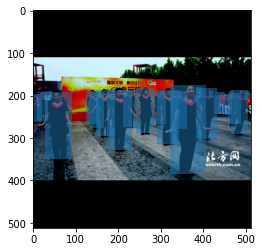

tf.Tensor(
[[  0.       196.21036   20.474123 261.89816 ]
 [  9.383973 197.06345   34.976627 260.192   ]
 [ 28.15192  191.09181   92.13355  348.91318 ]
 [123.69783  188.53255  155.2621   267.86978 ]
 [131.37563  192.798    165.49916  277.25375 ]
 [147.5843   187.67946  191.94492  295.1686  ]
 [174.03004  185.97328  232.04007  328.43906 ]
 [211.56595  187.67946  245.68948  273.8414  ]
 [242.27713  183.41402  284.07846  287.4908  ]
 [280.6661   189.38564  313.08347  267.86978 ]
 [291.75626  187.67946  343.79465  313.93655 ]
 [324.1736   188.53255  361.7095   279.81302 ]
 [321.61435  175.73622  406.92322  384.74292 ]
 [383.0367   183.41402  431.66278  302.8464  ]
 [431.66278  191.94492  452.1369   243.13022 ]
 [447.01837  195.35727  467.4925   244.8364  ]
 [458.9616   193.6511   488.8197   267.0167  ]
 [464.93323  187.67946  506.73456  291.75626 ]
 [424.83807  197.91653  442.75293  243.13022 ]
 [ 26.445744 188.53255   45.213688 209.00668 ]
 [383.0367   179.14857  397.53925  195.35727 ]
 [

<Figure size 432x288 with 0 Axes>

In [5]:
train_set_rot = DatasetGenerator(data_dir, input_size, output_size, batch_size).get_tfdataset(True, 660, [])
for images_batch, bboxes_batch in train_set_rot.take(1):
    for image, bboxes in zip(images_batch, bboxes_batch):
        valid_bboxes = bboxes[tf.reduce_any(bboxes != 0, axis=-1)]
        draw_bbox(image, valid_bboxes)
        print(valid_bboxes)

### resize -- crop,pad

In [6]:
def resize_crop(image, bboxes, run_criteria=0.3, scale_min=0.7, scale_max=1.3):

    scale_factor = 1.3

    adjusted_image = _resize_image(image, scale_factor)
    adjusted_bboxes = _resize_bbox(last_coord_factor(image), bboxes, scale_factor)

    return adjusted_image, adjusted_bboxes

def resize_pad(image, bboxes):
    
    scale_factor = 0.7

    adjusted_image = _resize_image(image, scale_factor)
    adjusted_bboxes = _resize_bbox(last_coord_factor(image), bboxes, scale_factor)

    return adjusted_image, adjusted_bboxes

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


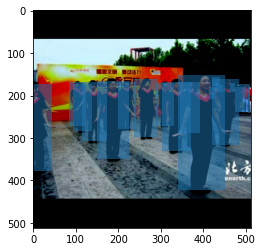

tf.Tensor(
[[  0.       171.76935   43.12361  376.93713 ]
 [ 84.15718  168.44232  125.190735 271.58072 ]
 [ 94.13832  173.98741  138.49892  283.77988 ]
 [115.209595 167.3333   172.87839  307.06918 ]
 [149.58907  165.11526  225.00209  350.32077 ]
 [198.38574  167.3333   242.74632  279.3438  ]
 [238.31027  161.78822  292.652    297.08807 ]
 [288.21594  169.55133  330.35852  271.58072 ]
 [302.63312  167.3333   370.28302  331.46753 ]
 [344.7757   168.44232  393.57233  287.10693 ]
 [341.44867  151.8071   452.35016  423.5158  ]
 [421.29773  161.78822  484.5116   317.05032 ]
 [484.5116   172.87839  511.       239.41928 ]
 [504.47388  177.31445  511.       241.63731 ]
 [475.63947  180.6415   498.9288   239.41928 ]
 [421.29773  156.24315  440.151    177.31445 ]
 [414.64362  180.6415   430.16986  207.25786 ]
 [429.06085  175.09642  446.8051   191.73164 ]
 [462.3313   170.66034  474.53046  190.62263 ]], shape=(19, 4), dtype=float32)


<Figure size 432x288 with 0 Axes>

In [7]:
train_set_rot = DatasetGenerator(data_dir, input_size, output_size, batch_size).get_tfdataset(True, 660, [resize_crop])
for images_batch, bboxes_batch in train_set_rot.take(1):
    for image, bboxes in zip(images_batch, bboxes_batch):
        valid_bboxes = bboxes[tf.reduce_any(bboxes != 0, axis=-1)]
        
        draw_bbox(image, valid_bboxes)
        print(valid_bboxes)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


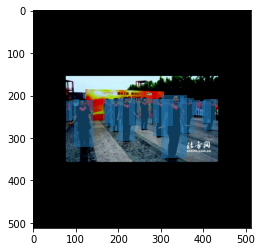

tf.Tensor(
[[ 76.65001  213.99725   90.98189  259.9787  ]
 [ 83.21878  214.59442  101.13364  258.7844  ]
 [ 96.35634  210.41428  141.1435   320.88922 ]
 [163.23848  208.62279  185.33347  264.15884 ]
 [168.61295  211.60861  192.49942  270.72763 ]
 [179.95901  208.02562  211.01144  283.26804 ]
 [198.47104  206.8313   239.07805  306.55734 ]
 [224.74617  208.02562  248.63264  268.339   ]
 [246.24399  205.03981  275.5049   277.89355 ]
 [273.11627  209.21994  295.8084   264.15884 ]
 [280.8794   208.02562  317.30624  296.40558 ]
 [303.57153  208.62279  329.84665  272.5191  ]
 [301.78003  199.66536  361.49625  345.97003 ]
 [344.7757   205.03981  378.81393  288.6425  ]
 [378.81393  211.01144  393.1458   246.84116 ]
 [389.56287  213.40009  403.89474  248.03548 ]
 [397.92313  212.20576  418.8238   263.56168 ]
 [402.10327  208.02562  431.3642   280.8794  ]
 [374.03665  215.19157  386.57703  246.84116 ]
 [ 95.16202  208.62279  108.299576 222.95468 ]
 [344.7757   202.054    354.92746  213.40009 ]
 [

<Figure size 432x288 with 0 Axes>

In [8]:
train_set_rot = DatasetGenerator(data_dir, input_size, output_size, batch_size).get_tfdataset(True, 660, [resize_pad])
for images_batch, bboxes_batch in train_set_rot.take(1):
    for image, bboxes in zip(images_batch, bboxes_batch):
        valid_bboxes = bboxes[tf.reduce_any(bboxes != 0, axis=-1)]
        
        draw_bbox(image, valid_bboxes)
        print(valid_bboxes)

### flip left_right

In [9]:
def flip_lr(image, bboxes):
    
    adjusted_image = _flip_lr_image(image)
    adjusted_bboxes = _flip_lr_bbox(last_coord_factor(image), bboxes)

    return adjusted_image, adjusted_bboxes

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


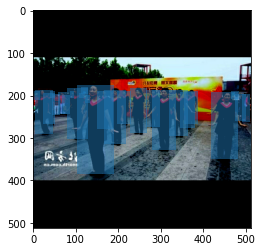

tf.Tensor(
[[490.52588  196.21036  511.       261.89816 ]
 [476.02338  197.06345  501.61603  260.192   ]
 [418.86646  191.09181  482.84808  348.91318 ]
 [355.7379   188.53255  387.3022   267.86978 ]
 [345.50085  192.798    379.6244   277.25375 ]
 [319.05508  187.67946  363.4157   295.1686  ]
 [278.95993  185.97328  336.96997  328.43906 ]
 [265.31052  187.67946  299.43405  273.8414  ]
 [226.92154  183.41402  268.72287  287.4908  ]
 [197.91653  189.38564  230.3339   267.86978 ]
 [167.20535  187.67946  219.24374  313.93655 ]
 [149.2905   188.53255  186.82639  279.81302 ]
 [104.07678  175.73622  189.38565  384.74292 ]
 [ 79.33722  183.41402  127.96329  302.8464  ]
 [ 58.8631   191.94492   79.33722  243.13022 ]
 [ 43.507507 195.35727   63.98163  244.8364  ]
 [ 22.180298 193.6511    52.03839  267.0167  ]
 [  4.265442 187.67946   46.066772 291.75626 ]
 [ 68.24707  197.91653   86.16193  243.13022 ]
 [465.78632  188.53255  484.55426  209.00668 ]
 [113.460754 179.14857  127.96329  195.35727 ]
 [

<Figure size 432x288 with 0 Axes>

In [10]:
train_set_rot = DatasetGenerator(data_dir, input_size, output_size, batch_size).get_tfdataset(True, 660, [flip_lr])
for images_batch, bboxes_batch in train_set_rot.take(1):
    for image, bboxes in zip(images_batch, bboxes_batch):
        valid_bboxes = bboxes[tf.reduce_any(bboxes != 0, axis=-1)]
        
        draw_bbox(image, valid_bboxes)
        print(valid_bboxes)

### rotate -- degree 10,90,120,180,200,270,300

In [11]:
def rotate10(image, bboxes, run_criteria=0.3, minval=1, maxval=359):
    degree_factor = random_factor(10, 10)
    degrees_to_radians = math.pi / 180.0
    radians = degree_factor * degrees_to_radians
    adjusted_image = _rotate_image(image, radians)
    adjusted_bboxes = _rotate_bbox(last_coord_factor(image), bboxes,
                                       radians)
    return adjusted_image, adjusted_bboxes

def rotate90(image, bboxes, run_criteria=0.3, minval=1, maxval=359):
    degree_factor = random_factor(90, 90)
    degrees_to_radians = math.pi / 180.0
    radians = degree_factor * degrees_to_radians
    adjusted_image = _rotate_image(image, radians)
    adjusted_bboxes = _rotate_bbox(last_coord_factor(image), bboxes,
                                       radians)
    return adjusted_image, adjusted_bboxes

def rotate120(image, bboxes, run_criteria=0.3, minval=1, maxval=359):
    degree_factor = random_factor(120, 120)
    degrees_to_radians = math.pi / 180.0
    radians = degree_factor * degrees_to_radians
    adjusted_image = _rotate_image(image, radians)
    adjusted_bboxes = _rotate_bbox(last_coord_factor(image), bboxes,
                                       radians)
    return adjusted_image, adjusted_bboxes

def rotate180(image, bboxes, run_criteria=0.3, minval=1, maxval=359):
    degree_factor = random_factor(180, 180)
    degrees_to_radians = math.pi / 180.0
    radians = degree_factor * degrees_to_radians
    adjusted_image = _rotate_image(image, radians)
    adjusted_bboxes = _rotate_bbox(last_coord_factor(image), bboxes,
                                       radians)
    return adjusted_image, adjusted_bboxes

def rotate200(image, bboxes, run_criteria=0.3, minval=1, maxval=359):
    degree_factor = random_factor(200, 200)
    degrees_to_radians = math.pi / 180.0
    radians = degree_factor * degrees_to_radians
    adjusted_image = _rotate_image(image, radians)
    adjusted_bboxes = _rotate_bbox(last_coord_factor(image), bboxes,
                                       radians)
    return adjusted_image, adjusted_bboxes

def rotate270(image, bboxes, run_criteria=0.3, minval=1, maxval=359):
    degree_factor = random_factor(270, 270)
    degrees_to_radians = math.pi / 180.0
    radians = degree_factor * degrees_to_radians
    adjusted_image = _rotate_image(image, radians)
    adjusted_bboxes = _rotate_bbox(last_coord_factor(image), bboxes,
                                       radians)
    return adjusted_image, adjusted_bboxes

def rotate300(image, bboxes, run_criteria=0.3, minval=1, maxval=359):
    degree_factor = random_factor(300, 300)
    degrees_to_radians = math.pi / 180.0
    radians = degree_factor * degrees_to_radians
    adjusted_image = _rotate_image(image, radians)
    adjusted_bboxes = _rotate_bbox(last_coord_factor(image), bboxes,
                                       radians)
    return adjusted_image, adjusted_bboxes


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


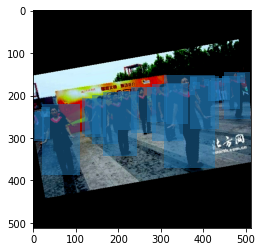

tf.Tensor(
[[  0.        237.92291    25.155716  306.16806  ]
 [  2.9756317 236.24472    39.141632  302.8583   ]
 [ 20.421478  220.4386    110.83647   386.9726   ]
 [114.07144   206.95605   158.93292   290.56906  ]
 [122.373276  209.37907   170.64398   298.47723  ]
 [137.44687   199.74603   199.79884   313.30533  ]
 [163.19458   191.10333   245.06221   341.47806  ]
 [200.4565    190.41339   249.02348   281.19183  ]
 [229.96042   179.54657   289.19943   289.30093  ]
 [268.80313   180.3908    314.35663   263.3118   ]
 [279.42853   173.3776    352.60065   306.75293  ]
 [311.50153   171.10684   364.31784   267.51862  ]
 [306.7591    150.65366   427.06555   371.2988   ]
 [368.58154   153.91882   437.20807   279.9806   ]
 [417.95026   158.76482   447.00153   212.7278   ]
 [433.6651    159.45886   462.42014   211.74158  ]
 [445.1306    154.07518   487.2749    231.51099  ]
 [449.97455   145.08339   509.21356   254.83774  ]
 [412.26617   166.27524   437.76013   213.9129   ]
 [ 18.296814  226.06

<Figure size 432x288 with 0 Axes>

In [12]:
train_set_rot = DatasetGenerator(data_dir, input_size, output_size, batch_size).get_tfdataset(True, 660, [rotate10])
for images_batch, bboxes_batch in train_set_rot.take(1):
    for image, bboxes in zip(images_batch, bboxes_batch):
        valid_bboxes = bboxes[tf.reduce_any(bboxes != 0, axis=-1)]
        
        draw_bbox(image, valid_bboxes)
        print(valid_bboxes)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


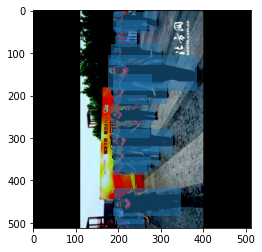

tf.Tensor(
[[196.21037  490.52588  261.89816  511.      ]
 [197.06346  476.02338  260.192    501.61603 ]
 [191.09183  418.86646  348.91318  482.84808 ]
 [188.53256  355.7379   267.86978  387.3022  ]
 [192.798    345.50085  277.25375  379.6244  ]
 [187.67946  319.05508  295.1686   363.4157  ]
 [185.97328  278.95993  328.43906  336.96997 ]
 [187.67946  265.31052  273.8414   299.43405 ]
 [183.41402  226.92154  287.4908   268.72287 ]
 [189.38564  197.91653  267.86978  230.3339  ]
 [187.67944  167.20535  313.93655  219.24374 ]
 [188.53253  149.2905   279.81302  186.82639 ]
 [175.7362   104.07678  384.74292  189.38565 ]
 [183.414     79.33722  302.8464   127.96329 ]
 [191.94492   58.8631   243.13022   79.33722 ]
 [195.35727   43.507507 244.83638   63.98163 ]
 [193.65108   22.180298 267.0167    52.03839 ]
 [187.67944    4.265442 291.75626   46.066772]
 [197.91653   68.24707  243.13022   86.16193 ]
 [188.53256  465.78632  209.0067   484.55426 ]
 [179.14856  113.460754 195.35727  127.96329 ]
 [

<Figure size 432x288 with 0 Axes>

In [13]:
train_set_rot = DatasetGenerator(data_dir, input_size, output_size, batch_size).get_tfdataset(True, 660, [rotate90])
for images_batch, bboxes_batch in train_set_rot.take(1):
    for image, bboxes in zip(images_batch, bboxes_batch):
        valid_bboxes = bboxes[tf.reduce_any(bboxes != 0, axis=-1)]
        
        draw_bbox(image, valid_bboxes)
        print(valid_bboxes)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


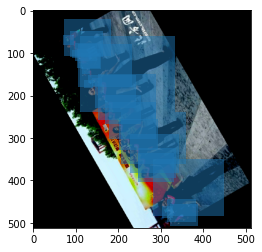

tf.Tensor(
[[321.66663  455.8393   388.791    506.4143  ]
 [315.15417  444.13284  382.6214   497.86102 ]
 [281.4041   350.2729   450.07224  484.59332 ]
 [247.62344  336.12366  332.11365  403.12775 ]
 [246.1989   322.56613  336.4015   394.34586 ]
 [228.54324  290.706    343.8119   382.868   ]
 [207.01807  239.34737  359.40204  360.81842 ]
 [201.67094  254.82545  293.35114  327.45828 ]
 [178.78247  214.75491  289.81628  302.99432 ]
 [169.45154  199.44637  253.62949  266.7627  ]
 [152.61836  149.81631  287.9794   258.01144 ]
 [144.39972  151.36337  242.21887  229.51064 ]
 [110.71094   59.742188 334.37048  238.12518 ]
 [104.99031   79.26535  232.73483  181.09297 ]
 [102.14122   91.392334 156.70605  134.7161  ]
 [ 97.41861   77.24092  150.50586  119.71159 ]
 [ 85.277405  47.680862 163.74292  110.22154 ]
 [ 71.14839   19.796371 182.1822   108.03578 ]
 [112.00479   99.519104 160.11841  137.64066 ]
 [302.64764  460.85992  329.76276  487.35052 ]
 [118.35809  162.56178  139.6465   183.2257  ]
 [

<Figure size 432x288 with 0 Axes>

In [14]:
train_set_rot = DatasetGenerator(data_dir, input_size, output_size, batch_size).get_tfdataset(True, 660, [rotate120])
for images_batch, bboxes_batch in train_set_rot.take(1):
    for image, bboxes in zip(images_batch, bboxes_batch):
        valid_bboxes = bboxes[tf.reduce_any(bboxes != 0, axis=-1)]
        
        draw_bbox(image, valid_bboxes)
        print(valid_bboxes)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


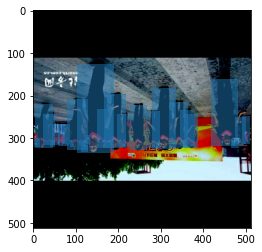

tf.Tensor(
[[490.52588  249.10182  511.       314.7896  ]
 [476.02338  250.808    501.61603  313.93652 ]
 [418.86646  162.08679  482.84808  319.90817 ]
 [355.7379   243.1302   387.3022   322.46744 ]
 [345.50085  233.74623  379.6244   318.202   ]
 [319.05508  215.83139  363.4157   323.32053 ]
 [278.95993  182.56094  336.96997  325.02673 ]
 [265.31052  237.1586   299.43405  323.32056 ]
 [226.92154  223.50919  268.72287  327.586   ]
 [197.91653  243.13022  230.3339   321.61438 ]
 [167.20535  197.06345  219.24374  323.32056 ]
 [149.2905   231.18698  186.82639  322.46747 ]
 [104.07677  126.25708  189.38565  335.2638  ]
 [ 79.33722  208.15361  127.963295 327.586   ]
 [ 58.8631   267.8698    79.33722  319.0551  ]
 [ 43.507507 266.16364   63.98163  315.64276 ]
 [ 22.180298 243.98332   52.03839  317.34894 ]
 [  4.265442 219.24376   46.066772 323.32056 ]
 [ 68.24707  267.8698    86.16193  313.0835  ]
 [465.78632  301.9933   484.55426  322.46744 ]
 [113.460754 315.64273  127.963295 331.85144 ]
 [

<Figure size 432x288 with 0 Axes>

In [15]:
train_set_rot = DatasetGenerator(data_dir, input_size, output_size, batch_size).get_tfdataset(True, 660, [rotate180])
for images_batch, bboxes_batch in train_set_rot.take(1):
    for image, bboxes in zip(images_batch, bboxes_batch):
        valid_bboxes = bboxes[tf.reduce_any(bboxes != 0, axis=-1)]
        
        draw_bbox(image, valid_bboxes)
        print(valid_bboxes)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


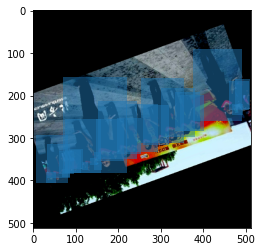

tf.Tensor(
[[474.1638    162.10155   511.        230.83044  ]
 [461.11945   166.91434   506.7599    234.98895  ]
 [377.06506    89.96271   491.1662    260.1493   ]
 [345.4621    198.79721   402.25775   284.14545  ]
 [332.6329    192.60512   393.5841    283.6385   ]
 [301.6548    181.31436   380.10358   297.49335  ]
 [252.5985    159.09534   355.83624   312.80997  ]
 [258.44574   223.23839   319.9805    315.87506  ]
 [217.70352   220.91599   292.5803    333.01306  ]
 [197.15854   252.48352   254.46404   337.3219   ]
 [152.5437    212.98798   244.62625   349.42902  ]
 [147.38017   256.141     213.87213   354.7546   ]
 [ 69.005035  156.66382   220.65366   382.24323  ]
 [ 73.767715  254.62906   160.30956   383.48987  ]
 [ 74.95247   327.375     111.69826   382.476    ]
 [ 59.939392  331.02365    96.10162   384.5214   ]
 [ 32.31227   314.2658     85.46219   393.419    ]
 [  7.0163727 293.06064    81.89313   405.15775  ]
 [ 83.77052   325.04083   116.06897   373.65503  ]
 [469.00616   220.84

<Figure size 432x288 with 0 Axes>

In [16]:
train_set_rot = DatasetGenerator(data_dir, input_size, output_size, batch_size).get_tfdataset(True, 660, [rotate200])
for images_batch, bboxes_batch in train_set_rot.take(1):
    for image, bboxes in zip(images_batch, bboxes_batch):
        valid_bboxes = bboxes[tf.reduce_any(bboxes != 0, axis=-1)]
        
        draw_bbox(image, valid_bboxes)
        print(valid_bboxes)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


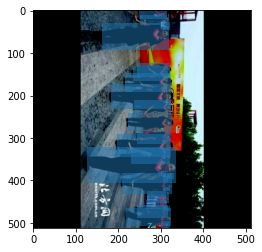

tf.Tensor(
[[249.10184    0.       314.78964   20.474121]
 [250.80801    9.383972 313.93655   34.976624]
 [162.08682   28.151917 319.9082    92.133545]
 [243.13022  123.69783  322.46747  155.2621  ]
 [233.74625  131.37563  318.202    165.49916 ]
 [215.83139  147.5843   323.32056  191.94492 ]
 [182.56094  174.03004  325.02673  232.04007 ]
 [237.1586   211.56595  323.32056  245.68948 ]
 [223.50919  242.27713  327.586    284.07846 ]
 [243.13022  280.6661   321.61438  313.08347 ]
 [197.06345  291.75626  323.32056  343.79465 ]
 [231.18698  324.1736   322.46747  361.7095  ]
 [126.25708  321.61435  335.2638   406.92322 ]
 [208.1536   383.0367   327.586    431.66278 ]
 [267.86978  431.66278  319.05508  452.1369  ]
 [266.1636   447.01837  315.64273  467.4925  ]
 [243.9833   458.9616   317.3489   488.8197  ]
 [219.24374  464.93323  323.32056  506.73456 ]
 [267.86978  424.83807  313.08347  442.75293 ]
 [301.99332   26.44574  322.46747   45.213684]
 [315.64273  383.0367   331.85144  397.53925 ]
 [

<Figure size 432x288 with 0 Axes>

In [17]:
train_set_rot = DatasetGenerator(data_dir, input_size, output_size, batch_size).get_tfdataset(True, 660, [rotate270])
for images_batch, bboxes_batch in train_set_rot.take(1):
    for image, bboxes in zip(images_batch, bboxes_batch):
        valid_bboxes = bboxes[tf.reduce_any(bboxes != 0, axis=-1)]
        
        draw_bbox(image, valid_bboxes)
        print(valid_bboxes)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


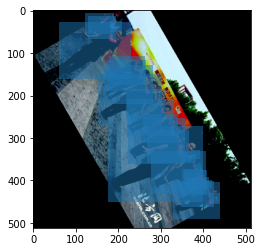

tf.Tensor(
[[122.209045   4.585678 189.33342   55.16069 ]
 [128.37863   13.138977 195.84589   66.86714 ]
 [ 60.927795  26.406693 229.59592  160.72708 ]
 [178.88638  107.87225  263.3766   174.87631 ]
 [174.59851  116.654144 264.80112  188.43387 ]
 [167.18814  128.13199  282.4568   220.29398 ]
 [151.59795  150.1816   303.98193  271.65262 ]
 [217.64886  183.54173  309.32904  256.17453 ]
 [221.18372  208.00568  332.21753  296.2451  ]
 [257.3705   244.23732  341.54846  311.55365 ]
 [223.02058  252.98857  358.38162  361.1837  ]
 [268.7811   281.48938  366.60028  359.63666 ]
 [176.62952  272.87482  400.28906  451.2578  ]
 [278.26514  329.90704  406.00967  431.73465 ]
 [354.2939   376.2839   408.85876  419.60767 ]
 [360.49414  391.28842  413.58136  433.7591  ]
 [347.25705  400.77847  425.72256  463.31915 ]
 [328.81775  402.96423  439.85156  491.20364 ]
 [350.88156  373.35934  398.99518  411.4809  ]
 [181.23729   23.64946  208.35237   50.140045]
 [371.3535   327.77432  392.64188  348.43823 ]
 [

<Figure size 432x288 with 0 Axes>

In [18]:
train_set_rot = DatasetGenerator(data_dir, input_size, output_size, batch_size).get_tfdataset(True, 660, [rotate300])
for images_batch, bboxes_batch in train_set_rot.take(1):
    for image, bboxes in zip(images_batch, bboxes_batch):
        valid_bboxes = bboxes[tf.reduce_any(bboxes != 0, axis=-1)]
        
        draw_bbox(image, valid_bboxes)
        print(valid_bboxes)

### translate(x-axis)

In [19]:
def translateX(image,bboxes,run_criteria=0.3,minval=-8,maxval=8):
    translate_factor = 8
    adjusted_image = _translateX_image(image, translate_factor)
    adjusted_bboxes = _translateX_bbox(last_coord_factor(image), bboxes,
                                           translate_factor)
    return adjusted_image, adjusted_bboxes

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


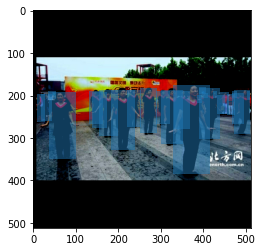

tf.Tensor(
[[  8.       196.21036   28.474123 261.89816 ]
 [ 17.383972 197.06345   42.976627 260.192   ]
 [ 36.15192  191.09181  100.13355  348.91318 ]
 [131.69783  188.53255  163.2621   267.86978 ]
 [139.37563  192.798    173.49916  277.25375 ]
 [155.5843   187.67946  199.94492  295.1686  ]
 [182.03004  185.97328  240.04007  328.43906 ]
 [219.56595  187.67946  253.68948  273.8414  ]
 [250.27713  183.41402  292.07846  287.4908  ]
 [288.6661   189.38564  321.08347  267.86978 ]
 [299.75626  187.67946  351.79465  313.93655 ]
 [332.1736   188.53255  369.7095   279.81302 ]
 [329.61435  175.73622  414.92322  384.74292 ]
 [391.0367   183.41402  439.66278  302.8464  ]
 [439.66278  191.94492  460.1369   243.13022 ]
 [455.01837  195.35727  475.4925   244.8364  ]
 [466.9616   193.6511   496.8197   267.0167  ]
 [472.93323  187.67946  511.       291.75626 ]
 [432.83807  197.91653  450.75293  243.13022 ]
 [ 34.445744 188.53255   53.213688 209.00668 ]
 [391.0367   179.14857  405.53925  195.35727 ]
 [

<Figure size 432x288 with 0 Axes>

In [20]:
train_set_rot = DatasetGenerator(data_dir, input_size, output_size, batch_size).get_tfdataset(True, 660, [translateX])
for images_batch, bboxes_batch in train_set_rot.take(1):
    for image, bboxes in zip(images_batch, bboxes_batch):
        valid_bboxes = bboxes[tf.reduce_any(bboxes != 0, axis=-1)]
        
        draw_bbox(image, valid_bboxes)
        print(valid_bboxes)

In [21]:
def translateX(image,bboxes,run_criteria=0.3):
    translate_factor = 250
    adjusted_image = _translateX_image(image, translate_factor)
    adjusted_bboxes = _translateX_bbox(last_coord_factor(image), bboxes,
                                           translate_factor)
    return adjusted_image, adjusted_bboxes

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


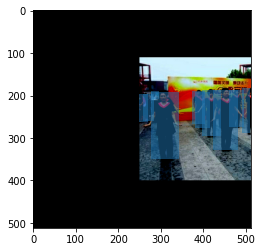

tf.Tensor(
[[250.      196.21036 270.47412 261.89816]
 [259.38397 197.06345 284.97662 260.192  ]
 [278.15192 191.09181 342.13354 348.91318]
 [373.6978  188.53255 405.2621  267.86978]
 [381.3756  192.798   415.49915 277.25375]
 [397.5843  187.67946 441.94492 295.1686 ]
 [424.03003 185.97328 482.04007 328.43906]
 [461.56595 187.67946 495.68948 273.8414 ]
 [492.27713 183.41402 511.      287.4908 ]
 [276.44574 188.53255 295.21368 209.00668]], shape=(10, 4), dtype=float32)


<Figure size 432x288 with 0 Axes>

In [22]:
train_set_rot = DatasetGenerator(data_dir, input_size, output_size, batch_size).get_tfdataset(True, 660, [translateX])
for images_batch, bboxes_batch in train_set_rot.take(1):
    for image, bboxes in zip(images_batch, bboxes_batch):
        valid_bboxes = bboxes[tf.reduce_any(bboxes != 0, axis=-1)]
        
        draw_bbox(image, valid_bboxes)
        print(valid_bboxes)

### translate(y-axis)

In [23]:
def translateY(image,bboxes,run_criteria=0.3,minval=-8,maxval=8):
    translate_factor = 8
    adjusted_image = _translateY_image(image, translate_factor)
    adjusted_bboxes = _translateY_bbox(last_coord_factor(image), bboxes,
                                           translate_factor)
    return adjusted_image, adjusted_bboxes

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


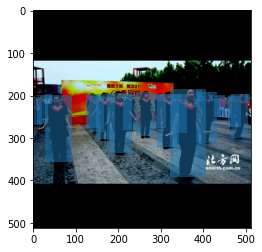

tf.Tensor(
[[  0.       204.21036   20.474123 269.89816 ]
 [  9.383973 205.06345   34.976627 268.192   ]
 [ 28.15192  199.09181   92.13355  356.91318 ]
 [123.69783  196.53255  155.2621   275.86978 ]
 [131.37563  200.798    165.49916  285.25375 ]
 [147.5843   195.67946  191.94492  303.1686  ]
 [174.03004  193.97328  232.04007  336.43906 ]
 [211.56595  195.67946  245.68948  281.8414  ]
 [242.27713  191.41402  284.07846  295.4908  ]
 [280.6661   197.38564  313.08347  275.86978 ]
 [291.75626  195.67946  343.79465  321.93655 ]
 [324.1736   196.53255  361.7095   287.81302 ]
 [321.61435  183.73622  406.92322  392.74292 ]
 [383.0367   191.41402  431.66278  310.8464  ]
 [431.66278  199.94492  452.1369   251.13022 ]
 [447.01837  203.35727  467.4925   252.8364  ]
 [458.9616   201.6511   488.8197   275.0167  ]
 [464.93323  195.67946  506.73456  299.75626 ]
 [424.83807  205.91653  442.75293  251.13022 ]
 [ 26.445744 196.53255   45.213688 217.00668 ]
 [383.0367   187.14857  397.53925  203.35727 ]
 [

<Figure size 432x288 with 0 Axes>

In [24]:
train_set_rot = DatasetGenerator(data_dir, input_size, output_size, batch_size).get_tfdataset(True, 660, [translateY])
for images_batch, bboxes_batch in train_set_rot.take(1):
    for image, bboxes in zip(images_batch, bboxes_batch):
        valid_bboxes = bboxes[tf.reduce_any(bboxes != 0, axis=-1)]
        
        draw_bbox(image, valid_bboxes)
        print(valid_bboxes)

In [25]:
def translateY(image,bboxes,run_criteria=0.3):
    translate_factor = 250
    adjusted_image = _translateY_image(image, translate_factor)
    adjusted_bboxes = _translateY_bbox(last_coord_factor(image), bboxes,
                                           translate_factor)
    return adjusted_image, adjusted_bboxes

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


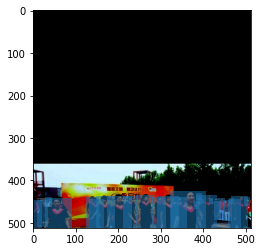

tf.Tensor(
[[  0.       446.21036   20.474123 511.      ]
 [  9.383973 447.06345   34.976627 510.192   ]
 [ 28.15192  441.0918    92.13355  511.      ]
 [123.69783  438.53253  155.2621   511.      ]
 [131.37563  442.798    165.49916  511.      ]
 [147.5843   437.67944  191.94492  511.      ]
 [174.03004  435.97327  232.04007  511.      ]
 [211.56595  437.67944  245.68948  511.      ]
 [242.27713  433.414    284.07846  511.      ]
 [280.6661   439.38562  313.08347  511.      ]
 [291.75626  437.67944  343.79465  511.      ]
 [324.1736   438.53253  361.7095   511.      ]
 [321.61435  425.7362   406.92322  511.      ]
 [383.0367   433.414    431.66278  511.      ]
 [431.66278  441.94492  452.1369   493.13022 ]
 [447.01837  445.35727  467.4925   494.8364  ]
 [458.9616   443.6511   488.8197   511.      ]
 [464.93323  437.67944  506.73456  511.      ]
 [424.83807  447.91653  442.75293  493.13022 ]
 [ 26.445744 438.53253   45.213688 459.00668 ]
 [383.0367   429.14856  397.53925  445.35727 ]
 [

<Figure size 432x288 with 0 Axes>

In [26]:
train_set_rot = DatasetGenerator(data_dir, input_size, output_size, batch_size).get_tfdataset(True, 660, [translateY])
for images_batch, bboxes_batch in train_set_rot.take(1):
    for image, bboxes in zip(images_batch, bboxes_batch):
        valid_bboxes = bboxes[tf.reduce_any(bboxes != 0, axis=-1)]
        
        draw_bbox(image, valid_bboxes)
        print(valid_bboxes)

### shear(x-axis) - transform function

In [27]:
def shearX(image, bboxes, run_criteria=0.3, minval=-0.3, maxval=0.3):
    shear_factor = 0.3
    adjusted_image = _shearX_image_shear_xFunc(image, shear_factor)
    adjusted_bboxes = _shearX_bbox(last_coord_factor(image), bboxes, shear_factor)
    return adjusted_image, adjusted_bboxes

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


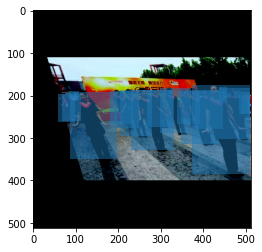

tf.Tensor(
[[ 58.86311  196.21036   99.04357  261.89816 ]
 [ 68.50301  197.06345  113.034225 260.192   ]
 [ 85.47946  191.09181  196.80751  348.91318 ]
 [180.2576   188.53255  235.62305  267.86978 ]
 [189.21503  192.798    248.6753   277.25375 ]
 [203.88815  187.67946  280.49548  295.1686  ]
 [229.82204  185.97328  330.57178  328.43906 ]
 [267.86978  187.67946  327.84192  273.8414  ]
 [297.30133  183.41402  370.3257   287.4908  ]
 [337.4818   189.38564  393.4444   267.86978 ]
 [348.0601   187.67946  437.97562  313.93655 ]
 [380.73337  188.53255  445.6534   279.81302 ]
 [374.3352   175.73622  511.       384.74292 ]
 [438.0609   183.41402  511.       302.8464  ]
 [489.24625  191.94492  511.       243.13022 ]
 [505.62555  195.35727  511.       244.8364  ]
 [484.21304  197.91653  511.       243.13022 ]
 [ 83.00551  188.53255  107.915695 209.00668 ]
 [436.78128  179.14857  456.14642  195.35727 ]
 [437.29315  197.91653  455.37866  218.39066 ]
 [447.1037   193.6511   464.592    206.44742 ]
 [

<Figure size 432x288 with 0 Axes>

In [28]:
train_set_rot = DatasetGenerator(data_dir, input_size, output_size, batch_size).get_tfdataset(True, 660, [shearX])
for images_batch, bboxes_batch in train_set_rot.take(1):
    for image, bboxes in zip(images_batch, bboxes_batch):
        valid_bboxes = bboxes[tf.reduce_any(bboxes != 0, axis=-1)]
        
        draw_bbox(image, valid_bboxes)
        print(valid_bboxes)

### shear(y-axis) - shear_y function

In [29]:
def shearY(image, bboxes, run_criteria=0.3, minval=-0.3, maxval=0.3):
    shear_factor = 0.3
    adjusted_image = _shearY_image_transformFunc(image, shear_factor)
    adjusted_bboxes = _shearY_bbox(last_coord_factor(image), bboxes, shear_factor)
    return adjusted_image, adjusted_bboxes

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


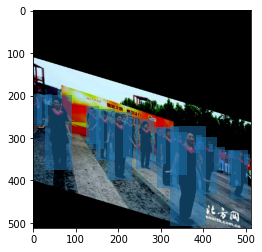

tf.Tensor(
[[  0.       196.21036   20.474123 268.0404  ]
 [  9.383973 199.87863   34.976627 270.68497 ]
 [ 28.15192  199.53738   92.13355  376.55325 ]
 [123.69783  225.6419   155.2621   314.44843 ]
 [131.37563  232.2107   165.49916  326.9035  ]
 [147.5843   231.95474  191.94492  352.75208 ]
 [174.03004  238.1823   232.04007  398.0511  ]
 [211.56595  251.14925  245.68948  347.54825 ]
 [242.27713  256.09717  284.07846  372.71436 ]
 [280.6661   273.58548  313.08347  361.79483 ]
 [291.75626  275.20633  343.79465  417.07495 ]
 [324.1736   285.78464  361.7095   388.32587 ]
 [321.61435  272.22052  406.92322  506.8199  ]
 [383.0367   298.32504  431.66278  432.34525 ]
 [431.66278  321.44376  452.1369   378.7713  ]
 [447.01837  329.46277  467.4925   385.08417 ]
 [458.9616   331.3396   488.8197   413.6626  ]
 [464.93323  327.15942  506.73456  443.7766  ]
 [424.83807  325.36795  442.75293  375.95612 ]
 [ 26.445744 196.46628   45.213688 222.57079 ]
 [383.0367   294.0596   397.53925  314.61905 ]
 [

<Figure size 432x288 with 0 Axes>

In [30]:
train_set_rot = DatasetGenerator(data_dir, input_size, output_size, batch_size).get_tfdataset(True, 660, [shearY])
for images_batch, bboxes_batch in train_set_rot.take(1):
    for image, bboxes in zip(images_batch, bboxes_batch):
        valid_bboxes = bboxes[tf.reduce_any(bboxes != 0, axis=-1)]
        
        draw_bbox(image, valid_bboxes)
        print(valid_bboxes)

# 3. Test crop_bbox code

### Before crop bboxes

In [31]:
def _resize_bbox(last_coord, bboxes, scale_factor):
    center = last_coord / 2
    valid_bboxes = bboxes[tf.reduce_any(bboxes != 0, axis=-1)]
    valid_bboxes = tf.reshape(valid_bboxes, (-1, 2))
    resized_bboxes = (valid_bboxes - center) @ [[scale_factor, 0], [0, scale_factor]] + center
    resized_bboxes = tf.reshape(resized_bboxes, (-1, 4))

#     if scale_factor > 1: resized_bboxes = _crop_bbox(last_coord, resized_bboxes)

    resized_bboxes = tf.pad(resized_bboxes, [[0, tf.shape(bboxes)[0] - tf.shape(resized_bboxes)[0]], [0, 0]],
                            'CONSTANT')
    return resized_bboxes

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


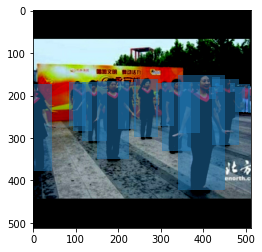

tf.Tensor(
[[-76.649994 178.42346  -50.03363  263.81763 ]
 [-64.450836 179.53249  -31.18039  261.59958 ]
 [-40.05249  171.76935   43.12361  376.93713 ]
 [ 84.15718  168.44232  125.190735 271.58072 ]
 [ 94.13832  173.98741  138.49892  283.77988 ]
 [115.209595 167.3333   172.87839  307.06918 ]
 [149.58907  165.11526  225.00209  350.32077 ]
 [198.38574  167.3333   242.74632  279.3438  ]
 [238.31027  161.78822  292.652    297.08807 ]
 [288.21594  169.55133  330.35852  271.58072 ]
 [302.63312  167.3333   370.28302  331.46753 ]
 [344.7757   168.44232  393.57233  287.10693 ]
 [341.44867  151.8071   452.35016  423.5158  ]
 [421.29773  161.78822  484.5116   317.05032 ]
 [484.5116   172.87839  511.12796  239.41928 ]
 [504.47388  177.31445  531.0902   241.63731 ]
 [520.0001   175.09642  558.8156   270.4717  ]
 [527.7632   167.3333   582.1049   302.63312 ]
 [475.63947  180.6415   498.9288   239.41928 ]
 [-42.27054  168.44232  -17.872192 195.05869 ]
 [421.29773  156.24315  440.151    177.31445 ]
 [

<Figure size 432x288 with 0 Axes>

In [32]:
train_set_rot = DatasetGenerator(data_dir, input_size, output_size, batch_size).get_tfdataset(True, 660, [resize_crop])
for images_batch, bboxes_batch in train_set_rot.take(1):
    for image, bboxes in zip(images_batch, bboxes_batch):
        valid_bboxes = bboxes[tf.reduce_any(bboxes != 0, axis=-1)]
        draw_bbox(image, valid_bboxes)
        print(valid_bboxes)

### After crop bboxes

In [33]:
def _resize_bbox(last_coord, bboxes, scale_factor):
    center = last_coord / 2
    valid_bboxes = bboxes[tf.reduce_any(bboxes != 0, axis=-1)]
    valid_bboxes = tf.reshape(valid_bboxes, (-1, 2))
    resized_bboxes = (valid_bboxes - center) @ [[scale_factor, 0], [0, scale_factor]] + center
    resized_bboxes = tf.reshape(resized_bboxes, (-1, 4))

    if scale_factor > 1: resized_bboxes = _crop_bbox(last_coord, resized_bboxes)

    resized_bboxes = tf.pad(resized_bboxes, [[0, tf.shape(bboxes)[0] - tf.shape(resized_bboxes)[0]], [0, 0]],
                            'CONSTANT')
    return resized_bboxes

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


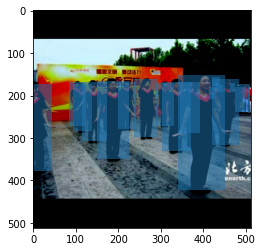

tf.Tensor(
[[  0.       171.76935   43.12361  376.93713 ]
 [ 84.15718  168.44232  125.190735 271.58072 ]
 [ 94.13832  173.98741  138.49892  283.77988 ]
 [115.209595 167.3333   172.87839  307.06918 ]
 [149.58907  165.11526  225.00209  350.32077 ]
 [198.38574  167.3333   242.74632  279.3438  ]
 [238.31027  161.78822  292.652    297.08807 ]
 [288.21594  169.55133  330.35852  271.58072 ]
 [302.63312  167.3333   370.28302  331.46753 ]
 [344.7757   168.44232  393.57233  287.10693 ]
 [341.44867  151.8071   452.35016  423.5158  ]
 [421.29773  161.78822  484.5116   317.05032 ]
 [484.5116   172.87839  511.       239.41928 ]
 [504.47388  177.31445  511.       241.63731 ]
 [475.63947  180.6415   498.9288   239.41928 ]
 [421.29773  156.24315  440.151    177.31445 ]
 [414.64362  180.6415   430.16986  207.25786 ]
 [429.06085  175.09642  446.8051   191.73164 ]
 [462.3313   170.66034  474.53046  190.62263 ]], shape=(19, 4), dtype=float32)


<Figure size 432x288 with 0 Axes>

In [34]:
train_set_rot = DatasetGenerator(data_dir, input_size, output_size, batch_size).get_tfdataset(True, 660, [resize_crop])
for images_batch, bboxes_batch in train_set_rot.take(1):
    for image, bboxes in zip(images_batch, bboxes_batch):
        valid_bboxes = bboxes[tf.reduce_any(bboxes != 0, axis=-1)]
        draw_bbox(image, valid_bboxes)
        print(valid_bboxes)

### padding images after crop images
- the number of images: 64

In [35]:
data_dir = 'data'
input_size = 512
output_size = input_size/4
batch_size = 64

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


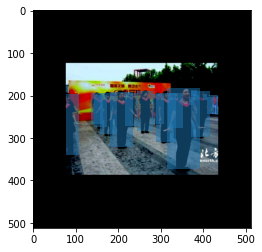

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


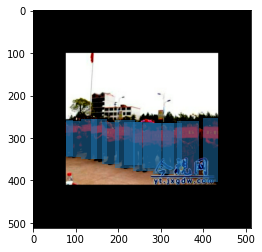

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


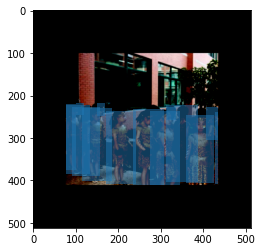

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


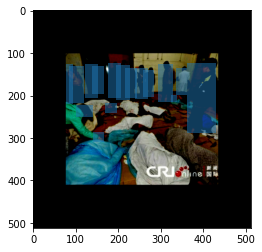

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


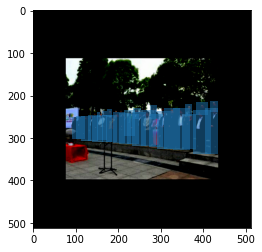

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


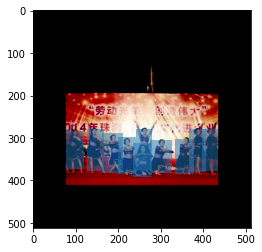

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


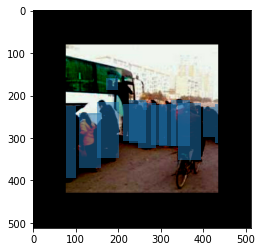

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


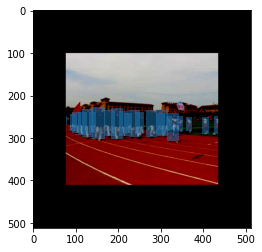

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


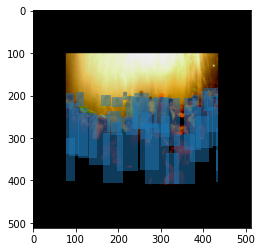

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


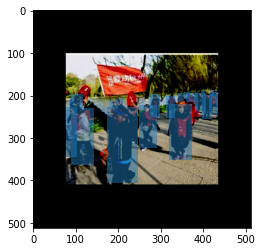

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


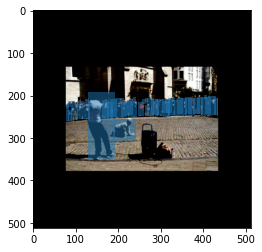

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


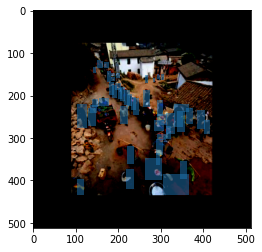

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


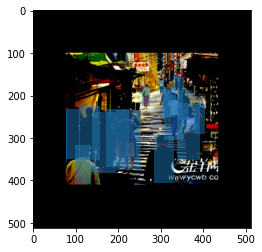

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


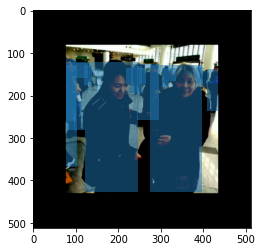

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


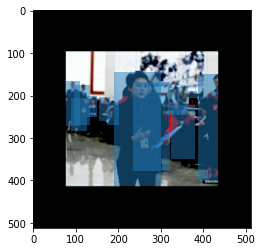

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


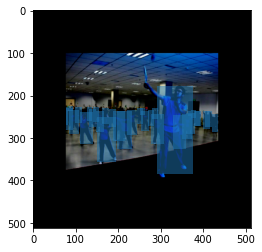

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


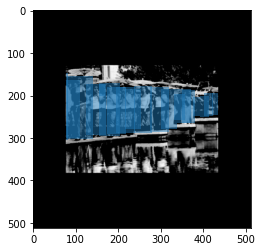

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


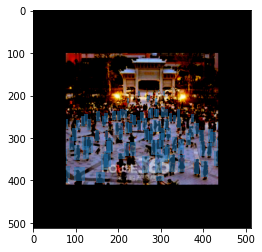

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


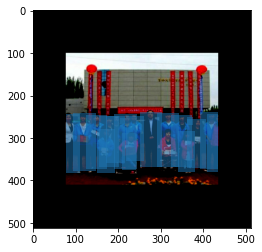

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


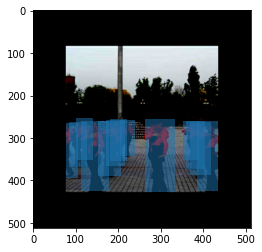

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


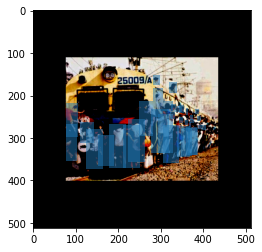

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


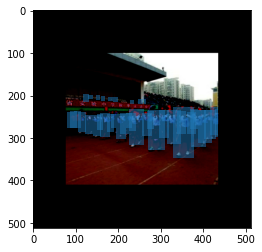

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


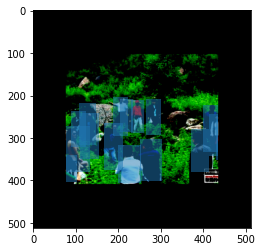

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


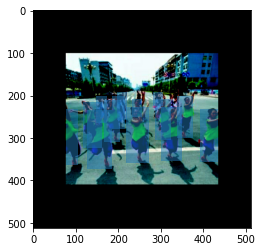

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


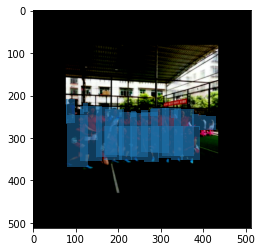

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


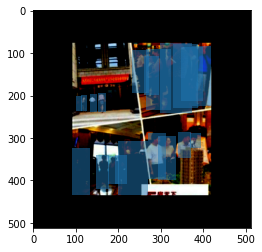

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


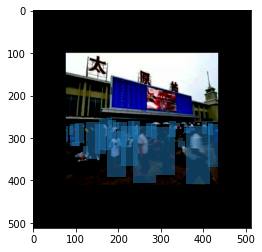

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


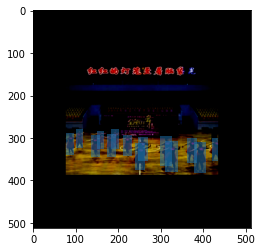

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


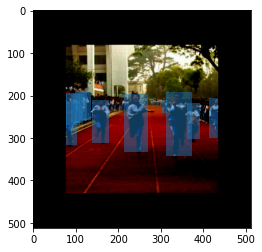

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


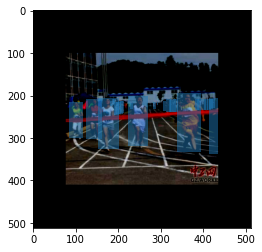

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


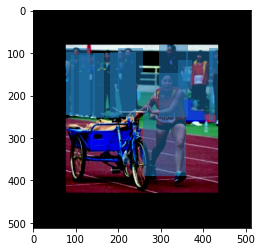

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


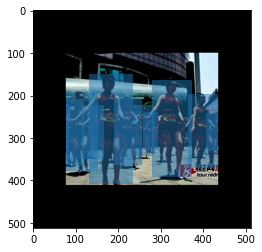

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


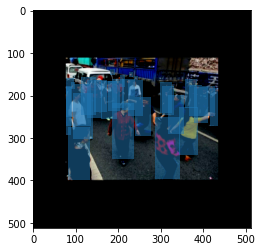

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


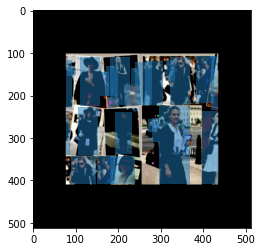

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


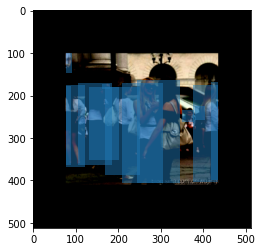

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


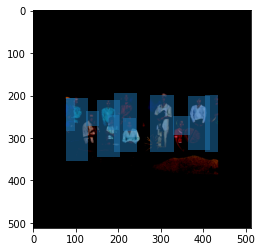

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


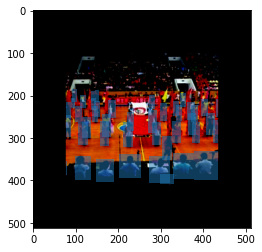

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


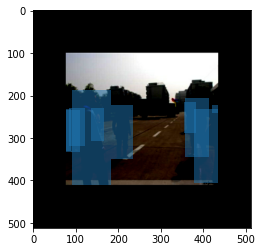

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


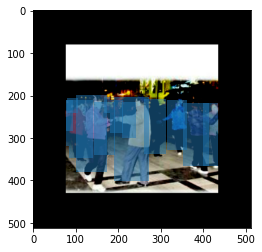

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


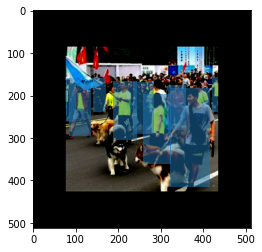

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


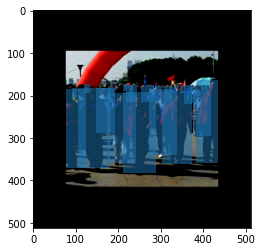

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


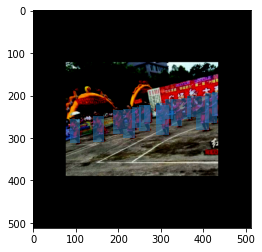

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


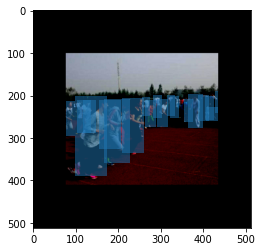

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


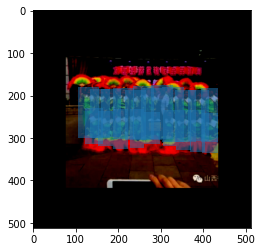

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


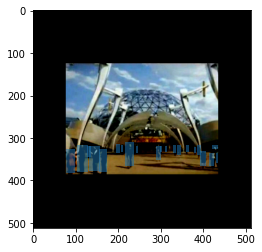

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


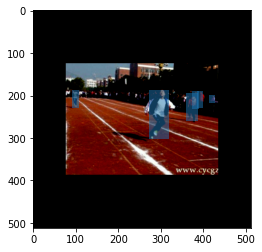

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


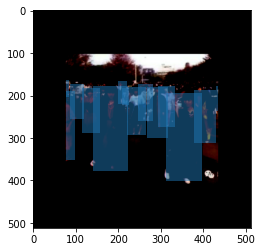

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


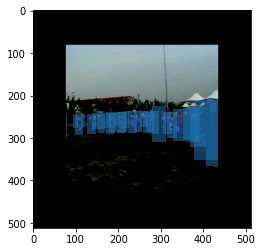

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


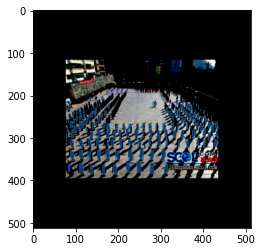

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


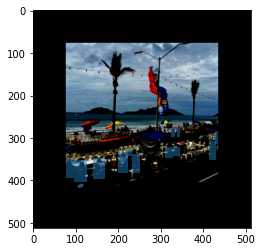

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


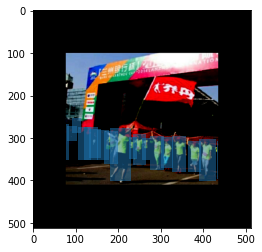

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


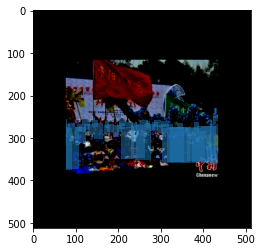

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


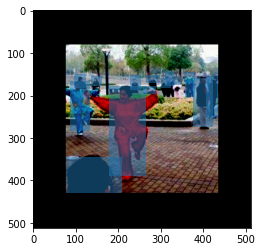

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


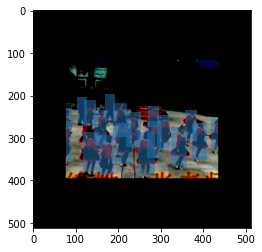

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


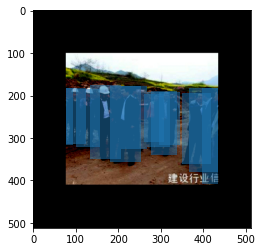

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


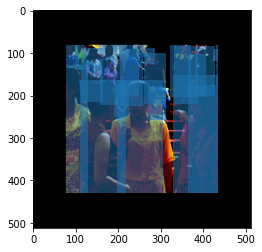

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


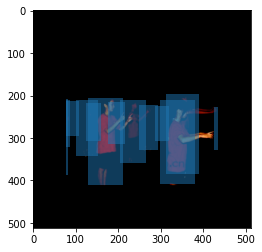

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


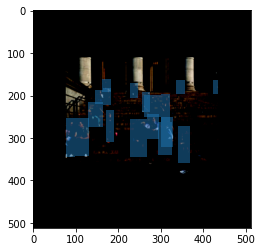

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


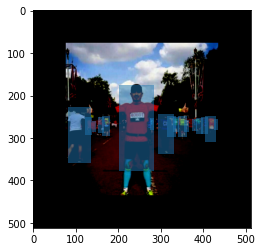

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


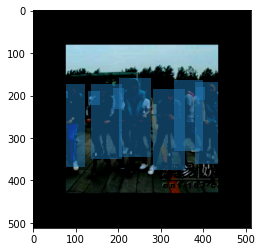

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


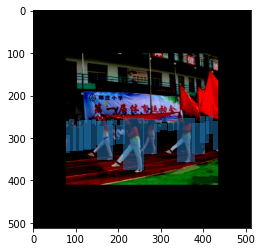

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


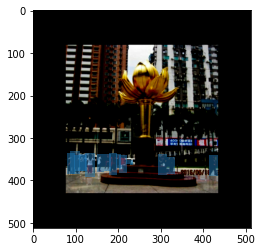

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


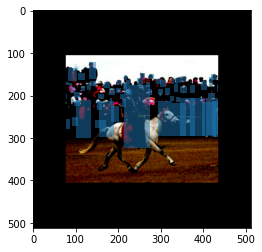

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


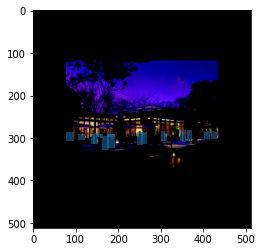

<Figure size 432x288 with 0 Axes>

In [36]:
train_set_rot = DatasetGenerator(data_dir, input_size, output_size, batch_size).get_tfdataset(True, 660, [resize_crop,resize_pad])
for images_batch, bboxes_batch in train_set_rot.take(1):
    for image, bboxes in zip(images_batch, bboxes_batch):
        valid_bboxes = bboxes[tf.reduce_any(bboxes != 0, axis=-1)]
        draw_bbox(image, valid_bboxes)